Log Analyzer
------------

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import re
import os
from datetime import datetime
from tqdm import tqdm
from dcevaluator.analyze.log_parser import LogParser

## Variables

In [6]:
MAX_NODES_PER_TURN = 112
pd.set_option("display.precision", 16)

# Single log Analyzer

In [32]:
LOG_PATH = "../../../log/DCDeepModelV4.0-reda-renault-speed_accel_gyro-batch128-1620155768.1678748.debug.log"

In [33]:
lp = LogParser(LOG_PATH)
print("Ok.")

131978it [00:01, 79512.07it/s]
Ok.


In [34]:
df_all_log_line = lp.data
df_all_log_line

,datetime,level,position,args,kwargs
0,2021-08-11 22:19:11.550,INFO,__main__:run:79,"[Donkey Car Evaluator, BEGIN]",{}
1,2021-08-11 22:19:11.550,INFO,__main__:run:80,[],{'evaluation_name': 'No Name'}
2,2021-08-11 22:19:11.550,INFO,__main__:run:81,[],{'host': '127.0.0.1'}
3,2021-08-11 22:19:11.550,INFO,__main__:run:82,[],{'port': '9091'}
4,2021-08-11 22:19:11.551,INFO,__main__:run:83,[],{'evaluation_scene': 'roboracingleague_1'}
...,...,...,...,...,...
131973,2021-08-12 00:08:42.205,SUCCESS,dcevaluator.communication.dc_client:each_turn:182,[NEW TURN],"{'turn': '10', 'deltatime': '646.6847207546234'}"
131974,2021-08-12 00:08:42.205,WARNING,dcevaluator.evaluator.evaluator:check_limit_tu...,[LIMIT],"{'message': 'Number of limit turns reached', '..."
131975,2021-08-12 00:08:42.208,SUCCESS,dcevaluator.evaluator.evaluator:end_evaluation...,"[EVALUATION, END]",{'epoch': '10'}
131976,2021-08-12 00:08:42.208,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '10', 'turn': '10', 'last_node': '0'..."


## Find log extremum and clip
Clip the logs between the beginning and the end of the evaluator in case the logs of several evaluators are mixed

### Find the evaluators limites

In [35]:
# Find the lines
log_begin_end = lp.find_evaluator_line()
log_begin_end

,datetime,level,position,args,kwargs
0,2021-08-11 22:19:11.550,INFO,__main__:run:79,"[Donkey Car Evaluator, BEGIN]",{}
131977,2021-08-12 00:08:42.210,INFO,dcevaluator.evaluator.evaluator:stop:118,"[Donkey Car Evaluator, END]",{}


### Clip the DataFrame to select only the evaluator which we are interested

In [36]:
# Clip and select only the evaluator which we are interested
df_current_log = df_all_log_line[0:131977]
df_current_log

,datetime,level,position,args,kwargs
0,2021-08-11 22:19:11.550,INFO,__main__:run:79,"[Donkey Car Evaluator, BEGIN]",{}
1,2021-08-11 22:19:11.550,INFO,__main__:run:80,[],{'evaluation_name': 'No Name'}
2,2021-08-11 22:19:11.550,INFO,__main__:run:81,[],{'host': '127.0.0.1'}
3,2021-08-11 22:19:11.550,INFO,__main__:run:82,[],{'port': '9091'}
4,2021-08-11 22:19:11.551,INFO,__main__:run:83,[],{'evaluation_scene': 'roboracingleague_1'}
...,...,...,...,...,...
131972,2021-08-12 00:08:42.204,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],{'first_time_on_first_turn': '1628719075.52059...
131973,2021-08-12 00:08:42.205,SUCCESS,dcevaluator.communication.dc_client:each_turn:182,[NEW TURN],"{'turn': '10', 'deltatime': '646.6847207546234'}"
131974,2021-08-12 00:08:42.205,WARNING,dcevaluator.evaluator.evaluator:check_limit_tu...,[LIMIT],"{'message': 'Number of limit turns reached', '..."
131975,2021-08-12 00:08:42.208,SUCCESS,dcevaluator.evaluator.evaluator:end_evaluation...,"[EVALUATION, END]",{'epoch': '10'}


## The current evaluator log Study

### Distance to center of the road

In [37]:
df_center_lines = df_current_log[df_current_log.position == "dcevaluator.communication.dc_client:on_telemetry:119"]
df_center_lines

,datetime,level,position,args,kwargs
22,2021-08-11 22:19:17.377,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '0', 'active_node': '112', 'last_node..."
23,2021-08-11 22:19:17.418,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '0', 'active_node': '112', 'last_node..."
24,2021-08-11 22:19:17.475,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '0', 'active_node': '112', 'last_node..."
25,2021-08-11 22:19:17.516,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '0', 'active_node': '112', 'last_node..."
26,2021-08-11 22:19:17.570,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '0', 'active_node': '112', 'last_node..."
...,...,...,...,...,...
131967,2021-08-12 00:08:42.003,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '9', 'active_node': '112', 'last_node..."
131968,2021-08-12 00:08:42.053,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '9', 'active_node': '112', 'last_node..."
131969,2021-08-12 00:08:42.104,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '9', 'active_node': '112', 'last_node..."
131970,2021-08-12 00:08:42.154,DEBUG,dcevaluator.communication.dc_client:on_telemet...,[],"{'turn': '9', 'active_node': '112', 'last_node..."


In [38]:
df_center = pd.DataFrame(df_center_lines.kwargs.to_list())
df_center.turn= df_center.turn.astype("int64")
df_center.active_node = df_center.active_node.astype("int64")
df_center.last_node = df_center.last_node.astype("int64")
df_center.distance_center = df_center.distance_center.astype("float64")
df_center

,turn,active_node,last_node,distance_center
0,0,112,-1,0.3282169
1,0,112,112,0.3282155
2,0,112,112,0.3282131
3,0,112,112,0.3282115
4,0,112,112,0.3282171
...,...,...,...,...
130395,9,112,112,0.7680664
130396,9,112,112,0.7131463
130397,9,112,112,0.6760775
130398,9,112,112,0.6206709


In [39]:
df_center.distance_center.apply(lambda r: r if r >= 0 else -r).describe()

count    130400.0000000000000000
mean          0.6554627078093137
std           0.5080502443075682
min           0.0000996099000000
25%           0.2800924000000000
50%           0.5281145000000000
75%           0.9330677000000001
max           4.9327170000000002
Name: distance_center, dtype: float64

In [101]:
df_center_group = pd.DataFrame(df_center.values, index=[df_center.turn.to_list(), df_center.active_node.to_list()], columns=df_center.columns)
df_center_group

turn  active_node  last_node  distance_center
0 112   0.0        112.0       -1.0        0.3282169
  112   0.0        112.0      112.0        0.3282155
  112   0.0        112.0      112.0        0.3282131
  112   0.0        112.0      112.0        0.3282115
  112   0.0        112.0      112.0        0.3282171
...     ...          ...        ...              ...
9 112   9.0        112.0      112.0        0.7680664
  112   9.0        112.0      112.0        0.7131463
  112   9.0        112.0      112.0        0.6760775
  112   9.0        112.0      112.0        0.6206709
  0     9.0          0.0      112.0        0.5836462

[130400 rows x 4 columns]

In [102]:
df_dc_mean = df_center_group.distance_center.mean(axis=0, level=1)
df_dc_mean

/tmp/ipykernel_8164/3119278937.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_dc_mean = df_center_group.distance_center.mean(axis=0, level=1)


112    0.2647938052244776
0      0.1299497603363636
1     -0.5025249500000001
2      0.0695831480000000
3      0.0491849648200000
              ...        
107   -0.1624522084492147
108   -0.0945175650769474
109    0.8537002224736234
110    1.3957327544618228
111    0.7627406219657534
Name: distance_center, Length: 113, dtype: float64

Text(0, 0.5, 'Average distance of the car from the center of the road')

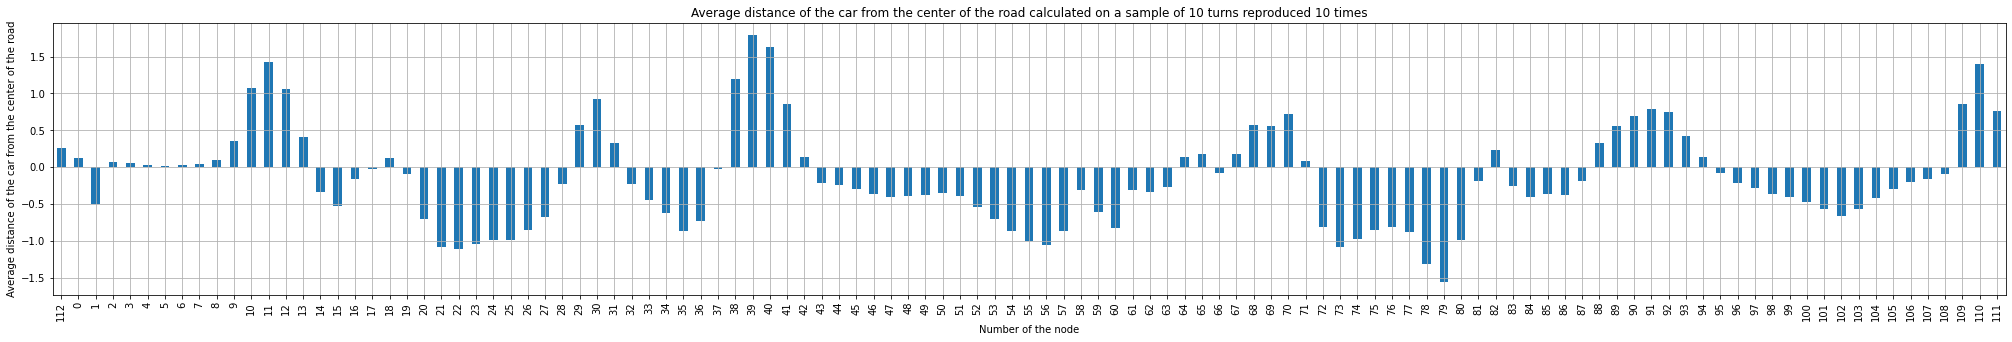

In [103]:
ax = df_dc_mean.plot.bar(figsize=(35,5), grid=True, title = "Average distance of the car from the center of the road calculated on a sample of 10 turns reproduced 10 times")
ax.set_xlabel("Number of the node")
ax.set_ylabel("Average distance of the car from the center of the road")

### Summary

In [104]:
summary = df_current_log[df_current_log.apply(lambda r: "SUMMARY" in r.args, axis = 1)]
summary

,datetime,level,position,args,kwargs
13357,2021-08-11 22:30:16.382,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '1', 'turn': '10', 'last_node': '0',..."
26531,2021-08-11 22:41:12.319,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '2', 'turn': '10', 'last_node': '0',..."
39733,2021-08-11 22:52:09.568,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '3', 'turn': '10', 'last_node': '0',..."
52870,2021-08-11 23:03:03.680,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '4', 'turn': '10', 'last_node': '0',..."
66051,2021-08-11 23:13:59.928,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '5', 'turn': '10', 'last_node': '0',..."
79221,2021-08-11 23:24:55.673,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '6', 'turn': '10', 'last_node': '0',..."
92384,2021-08-11 23:35:51.018,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '7', 'turn': '10', 'last_node': '0',..."
105599,2021-08-11 23:46:48.964,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '8', 'turn': '10', 'last_node': '0',..."
118835,2021-08-11 23:57:47.957,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '9', 'turn': '10', 'last_node': '0',..."
131976,2021-08-12 00:08:42.208,INFO,dcevaluator.evaluator.evaluator:end_evaluation...,[SUMMARY],"{'epoch': '10', 'turn': '10', 'last_node': '0'..."


In [71]:
df_summary = pd.DataFrame(summary.kwargs.to_list())
df_summary

,epoch,turn,last_node,first_time_on_first_turn,last_time_on_last_turn,last_time_on_last_node
0,1,10,0,1628713160.4351249,1628713816.3759778,1628713816.3766768
1,2,10,0,1628713823.9684958,1628714472.3173118,1628714472.3179266
2,3,10,0,1628714479.8857498,1628715129.5661519,1628715129.5666616
3,4,10,0,1628715137.1674418,1628715783.6781516,1628715783.6788762
4,5,10,0,1628715791.2681723,1628716439.9244783,1628716439.9252143
5,6,10,0,1628716447.5075681,1628717095.6699984,1628717095.6705706
6,7,10,0,1628717103.2740688,1628717751.0156364,1628717751.0162153
7,8,10,0,1628717758.6036873,1628718408.9566414,1628718408.960696
8,9,10,0,1628718416.563505,1628719067.9544992,1628719067.9566262
9,10,10,0,1628719075.5205925,1628719722.2053132,1628719722.2059677


In [105]:
df_summary.first_time_on_first_turn.astype('float128')

0    1.6287131604351249e+09
1    1.6287138239684958e+09
2    1.6287144798857498e+09
3    1.6287151371674418e+09
4    1.6287157912681723e+09
5    1.6287164475075681e+09
6    1.6287171032740688e+09
7    1.6287177586036873e+09
8    1.6287184165635049e+09
9    1.6287190755205925e+09
Name: first_time_on_first_turn, dtype: float128

In [93]:
df_summary = pd.DataFrame(summary.kwargs.to_list())
df_summary.epoch = df_summary.epoch.astype('int64')
df_summary.turn = df_summary.turn.astype('int64')
df_summary.last_node = df_summary.last_node.astype('int64')
df_summary.first_time_on_first_turn = df_summary.first_time_on_first_turn.astype('float64')
df_summary.last_time_on_last_turn = df_summary.last_time_on_last_turn.astype('float64')
df_summary.last_time_on_last_node = df_summary.last_time_on_last_node.astype('float64')
df_summary

,epoch,turn,last_node,first_time_on_first_turn,last_time_on_last_turn,last_time_on_last_node
0,1,10,0,1.6287131604351249e+09,1.6287138163759778e+09,1.6287138163766768e+09
1,2,10,0,1.6287138239684958e+09,1.6287144723173118e+09,1.6287144723179266e+09
2,3,10,0,1.6287144798857498e+09,1.6287151295661519e+09,1.6287151295666616e+09
3,4,10,0,1.6287151371674418e+09,1.6287157836781516e+09,1.6287157836788762e+09
4,5,10,0,1.6287157912681723e+09,1.6287164399244783e+09,1.6287164399252143e+09
5,6,10,0,1.6287164475075681e+09,1.6287170956699984e+09,1.6287170956705706e+09
6,7,10,0,1.6287171032740688e+09,1.6287177510156364e+09,1.6287177510162153e+09
7,8,10,0,1.6287177586036873e+09,1.6287184089566414e+09,1.6287184089606960e+09
8,9,10,0,1.6287184165635049e+09,1.6287190679544992e+09,1.6287190679566262e+09
9,10,10,0,1.6287190755205925e+09,1.6287197222053132e+09,1.6287197222059677e+09


#### Number of nodes
1 turn = 112 nodes on `roboracingleague_1`

In [95]:
df_max_node.describe()

count      10.0
mean     1120.0
std         0.0
min      1120.0
25%      1120.0
50%      1120.0
75%      1120.0
max      1120.0
dtype: float64

#### Time per turn

In [96]:
df_time_per_turn = df_summary.apply(lambda r: float(r.last_time_on_last_turn - r.first_time_on_first_turn)/float(r.turn), axis=1)
df_time_per_turn

0    65.5940852880477934
1    64.8348815917968722
2    64.9680402040481511
3    64.6510709762573299
4    64.8656306028366032
5    64.8162430286407414
6    64.7741567611694364
7    65.0352954149246187
8    65.1390994310379057
9    64.6684720754623470
dtype: float64

In [97]:
df_time_per_turn.describe()

count    10.0000000000000000
mean     64.9346975374221813
std       0.2776213057992367
min      64.6510709762573299
25%      64.7846783280372733
50%      64.8502560973167306
75%      65.0184816122055054
max      65.5940852880477934
dtype: float64

<AxesSubplot:>

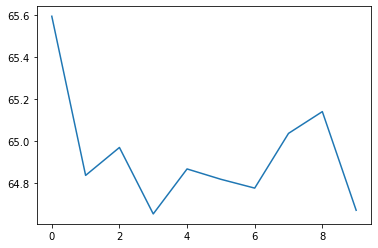

In [98]:
df_time_per_turn.plot()

# Multi-log Analyzer

In [11]:
LOG_DIR_PATH = "../../../log/DCDeepModelV4.0-reda-renault-speed_accel_gyro-1620332685.9264247"
list_lp = []
list_df = []

In [12]:
list_log = [ "72DCE_10_EPOCH.log",
             "73DCE_20_EPOCH.log",
             "74DCE_30_EPOCH.log",
             "75DCE_40_EPOCH.log",
             "76DCE_50_EPOCH.log",
             "77DCE_60_EPOCH.log",
             "78DCE_70_EPOCH.log",
             "79DCE_80_EPOCH.log",
             "80DCE_90_EPOCH.log",
             "81DCE_100_EPOCH.log"
            ]

In [13]:
for log_filename in list_log:
    lp = LogParser(os.path.join(LOG_DIR_PATH, log_filename))
    list_lp.append(lp)
    list_df.append(lp.data)

8528it [00:00, 50892.35it/s]
10901it [00:00, 105018.00it/s]
6587it [00:00, 99751.88it/s]
10001it [00:00, 103603.35it/s]
61135it [00:00, 79813.61it/s]
95244it [00:01, 86511.71it/s]
42677it [00:00, 112015.98it/s]
94176it [00:01, 80862.54it/s]
111458it [00:01, 93048.32it/s]
114045it [00:01, 91313.54it/s] 


## Summary

In [16]:
list_summary_df = []
for df_current_log in tqdm(list_df):
    summary = df_current_log[df_current_log.apply(lambda r: "SUMMARY" in r.args, axis = 1)]
    df_summary = pd.DataFrame(summary.kwargs.to_list())
    df_summary.epoch = df_summary.epoch.astype('int64')
    df_summary.turn = df_summary.turn.astype('int64')
    df_summary.last_node = df_summary.last_node.astype('int64')
    df_summary.first_time_on_first_turn = df_summary.first_time_on_first_turn.astype('float64')
    df_summary.last_time_on_last_turn = df_summary.last_time_on_last_turn.astype('float64')
    df_summary.last_time_on_last_node = df_summary.last_time_on_last_node.astype('float64')
    list_summary_df.append(df_summary)

100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


### Max node per model

In [21]:
dict_max_node_df = dict() 

for i, df_summary in enumerate(tqdm(list_summary_df)):
    df_max_node = df_summary.apply(lambda r: r.turn * MAX_NODES_PER_TURN + r.last_node, axis=1)
    dict_max_node_df[i * 10 + 10] = df_max_node


100%|██████████| 10/10 [00:00<00:00, 963.45it/s]


In [40]:
multi_max_node_df = pd.DataFrame(dict_max_node_df)
# Some time, when car reachs the limite of turns, the last_node doesn't have enough time to be refreshed and keep its last value, i.e. 112 instead of 0
multi_max_node_df[multi_max_node_df > 1120] = 1120
multi_max_node_df

,10,20,30,40,50,60,70,80,90,100
0,55.0,79.0,56.0,33.0,595.0,670.0,369.0,1120.0,1120.0,1120.0
1,58.0,80.0,64.0,79.0,105.0,107.0,512.0,1041.0,1120.0,1120.0
2,170.0,36.0,33.0,33.0,393.0,1120.0,480.0,593.0,1120.0,1120.0
3,56.0,104.0,32.0,56.0,333.0,1120.0,257.0,445.0,1120.0,1120.0
4,58.0,183.0,57.0,110.0,288.0,781.0,32.0,1120.0,1120.0,1120.0
5,56.0,7.0,56.0,78.0,1120.0,666.0,669.0,333.0,368.0,16.0
6,58.0,105.0,58.0,106.0,447.0,1120.0,368.0,1120.0,622.0,1120.0
7,27.0,78.0,56.0,78.0,1120.0,1114.0,480.0,954.0,1120.0,683.0
8,55.0,32.0,33.0,72.0,481.0,1120.0,144.0,669.0,670.0,1120.0
9,49.0,104.0,27.0,105.0,369.0,221.0,288.0,558.0,1040.0,1120.0


Text(0, 0.5, 'Nombre de noeuds atteints')

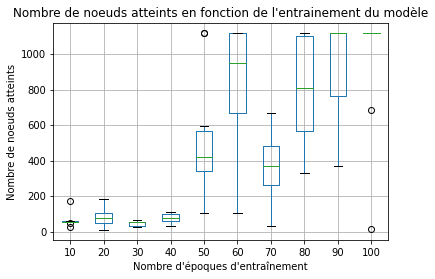

In [63]:
fig, ax = plt.subplots()
multi_max_node_df.boxplot(ax=ax)
ax.set_title("Nombre de noeuds atteints en fonction de l'entrainement du modèle")
ax.set_xlabel("Nombre d'époques d'entraînement")
ax.set_ylabel("Nombre de noeuds atteints")

### Distance to center per model

In [42]:
list_d2c_df = []
for df_current_log in tqdm(list_df):
    df_center_lines = df_current_log[df_current_log.position == "dcevaluator.communication.dc_client:on_telemetry:122"]
    df_center = pd.DataFrame(df_center_lines.kwargs.to_list())
    df_center.turn= df_center.turn.astype("int64")
    df_center.active_node = df_center.active_node.astype("int64")
    df_center.last_node = df_center.last_node.astype("int64")
    df_center.distance_center = df_center.distance_center.astype("float64")
    list_d2c_df.append(df_center.distance_center.apply(lambda r: r if r >= 0 else -r).describe())

100%|██████████| 10/10 [00:01<00:00,  7.77it/s]


In [52]:
x = [i for i in range(10, 110, 10)]
m = [d2c_df.get("mean") for d2c_df in list_d2c_df]
s = [d2c_df.get("std") for d2c_df in list_d2c_df]

In [53]:
m

[1.0603023584980733,
 1.0139402315126391,
 1.0330584665239153,
 0.9917313702764957,
 0.6314672170948386,
 0.5632245279912065,
 0.696350271062288,
 0.5732832731950032,
 0.6165623828051111,
 0.5992977974056847]

/tmp/ipykernel_12657/1637517537.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


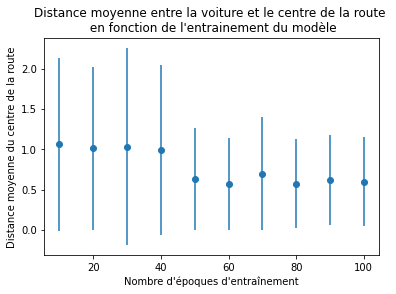

In [61]:
fig, ax = plt.subplots()

ax.errorbar(x, m, s, linestyle='None', marker='o')

ax.set_title("Distance moyenne entre la voiture et le centre de la route \n en fonction de l'entrainement du modèle")
ax.set_xlabel("Nombre d'époques d'entraînement")
ax.set_ylabel("Distance moyenne du centre de la route")
fig.show()